In [47]:
import numpy as np
import torch
import torch.nn as nn
from tensorflow.keras.datasets import mnist

## MNIST dataset compression and reconstruction using PCA and AutoEncoder.
- Train a PCA model to compress the digits to 4 dimensional latent vectors.
- Train an AutoEncoder model to compress the digits to 4 dimensional latent vectors.
- Visualize the latent vectors using TSNE( https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for both the cases.
- Show reconstruction for 20 latent samples using both models.
- What is the compression ratio achieved?


In [48]:
mnist_dataset = mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist_dataset

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

class MNISTAutoEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_channels, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, out_channels),
            nn.ReLU()
        )

    def get_latent_vectors(self, X_train):
        latent_vectors = []
        dataloader = torch.utils.data.DataLoader(X_train, batch_size=32, shuffle=False)
        for batch in dataloader:
            batch = batch.view(batch.size(0), -1).to(device)
            latent = self.encoder(batch)
            latent_vectors.append(latent.cpu().detach().numpy())
        return np.array(latent_vectors)
        
    
    def forward(self, x):
        x = self.encoder(x)
        self.latent_vector = x
        x = self.decoder(x)
        return x

    def train(self, X_train, batch_size=32, epochs=10, lr=1):
        dataloader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            total_loss = 0
            for batch in dataloader:
                # print(batch.shape)
                batch = batch.view(batch.size(0), -1)
                optimizer.zero_grad()
                output = self.forward(batch)
                loss = criterion(output, batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")


In [51]:
mnist_auto_encoder = MNISTAutoEncoder(784, 784, 4).to(device)
X_train = X_train / 255
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
mnist_auto_encoder.train(X_train, batch_size=32, epochs=20, lr=0.001)

Epoch [1/20], Loss: 0.0489
Epoch [2/20], Loss: 0.0350
Epoch [3/20], Loss: 0.0322
Epoch [4/20], Loss: 0.0306
Epoch [5/20], Loss: 0.0294
Epoch [6/20], Loss: 0.0287
Epoch [7/20], Loss: 0.0280
Epoch [8/20], Loss: 0.0275
Epoch [9/20], Loss: 0.0271
Epoch [10/20], Loss: 0.0269
Epoch [11/20], Loss: 0.0267
Epoch [12/20], Loss: 0.0264
Epoch [13/20], Loss: 0.0263
Epoch [14/20], Loss: 0.0261
Epoch [15/20], Loss: 0.0260
Epoch [16/20], Loss: 0.0258
Epoch [17/20], Loss: 0.0257
Epoch [18/20], Loss: 0.0256
Epoch [19/20], Loss: 0.0256
Epoch [20/20], Loss: 0.0254


In [52]:
# do PCA on the image data
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_train_copy1 = X_train.cpu().numpy()
print(X_train_copy1.shape)
X_train_copy1 = X_train_copy1.reshape(X_train.shape[0], -1)
print(X_train_copy1.shape)
pca.fit(X_train_copy1)
pca_x_train = pca.transform(X_train_copy1)

(60000, 28, 28)
(60000, 784)


In [53]:
X_train_copy2 = X_train
batched_latent_vectors = mnist_auto_encoder.get_latent_vectors(X_train)
mnist_latent_vector = np.vstack(batched_latent_vectors)
print(mnist_latent_vector.shape)

(60000, 4)


In [54]:
print(mnist_latent_vector.shape)
print(pca_x_train.shape)

(60000, 4)
(60000, 4)


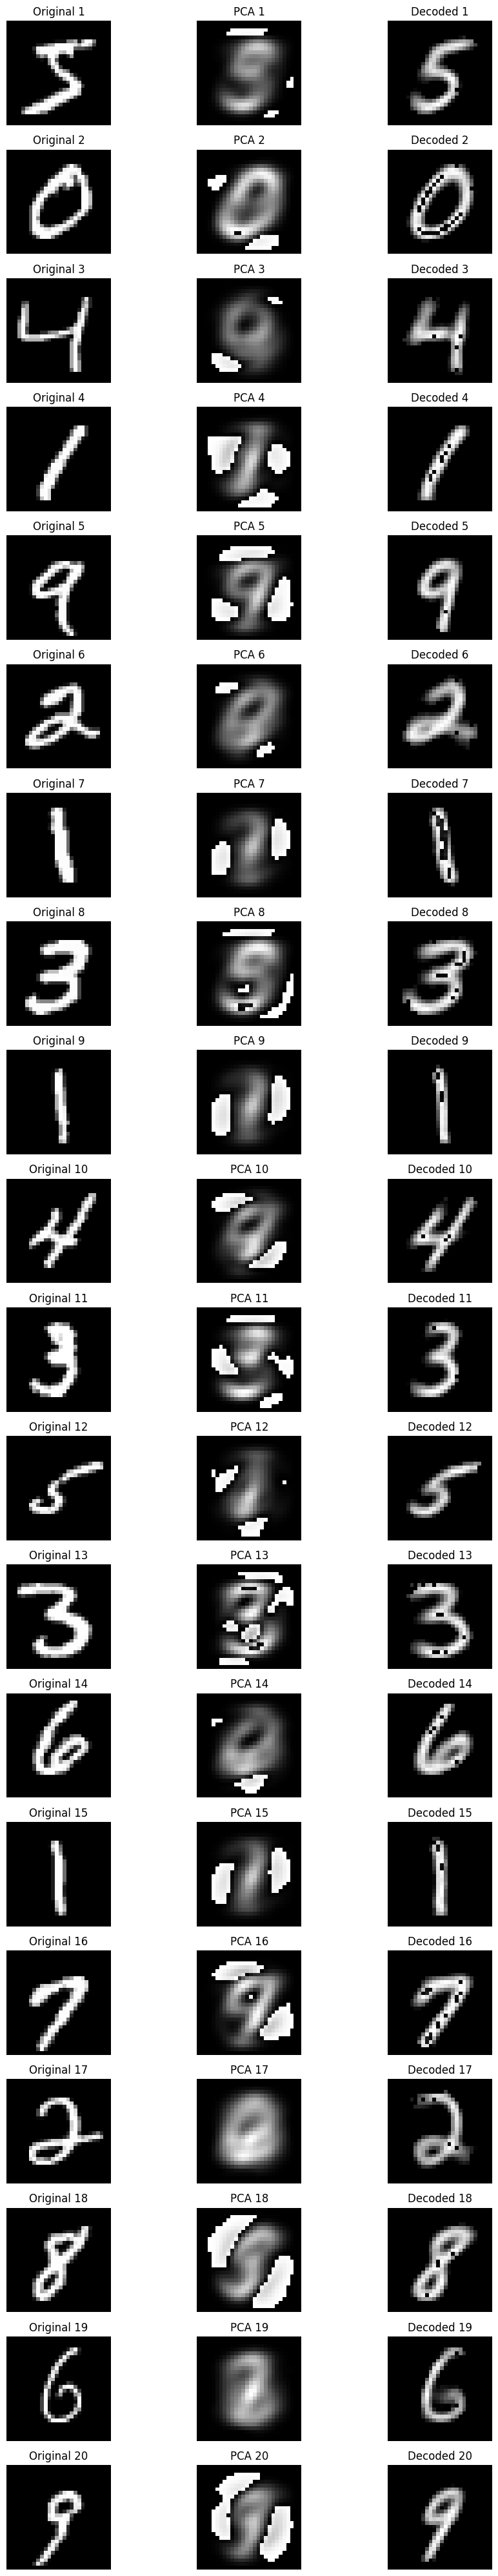

In [55]:
num_samples = 20
import matplotlib.pyplot as plt

# Decode using the autoencoder
decode_output = mnist_auto_encoder.decoder(torch.tensor(batched_latent_vectors).to(device))
decode_output = decode_output.detach().cpu().numpy() * 255
decode_output = decode_output.astype(np.uint8)
decode_output = decode_output.reshape(-1, 28, 28)

plt.figure(figsize=(10, 40))  # Adjust figure size for better visibility

for i in range(num_samples):
    # Original Image
    ax = plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(X_train[i].reshape(28, 28).cpu().numpy(), cmap='gray')
    ax.set_title(f"Original {i+1}")
    ax.axis("off")

    # PCA Inverse Transform
    pca_output = pca.inverse_transform(pca_x_train[i])
    pca_output = (pca_output * 255).astype(np.uint8).reshape(28, 28)

    ax = plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(pca_output, cmap='gray')
    ax.set_title(f"PCA {i+1}")
    ax.axis("off")

    # Decoded Output
    ax = plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(decode_output[i], cmap='gray')
    ax.set_title(f"Decoded {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [56]:
# To print the compression ratio
compression_ratio = 28 * 28/ batched_latent_vectors.shape[-1]
print(compression_ratio)

196.0


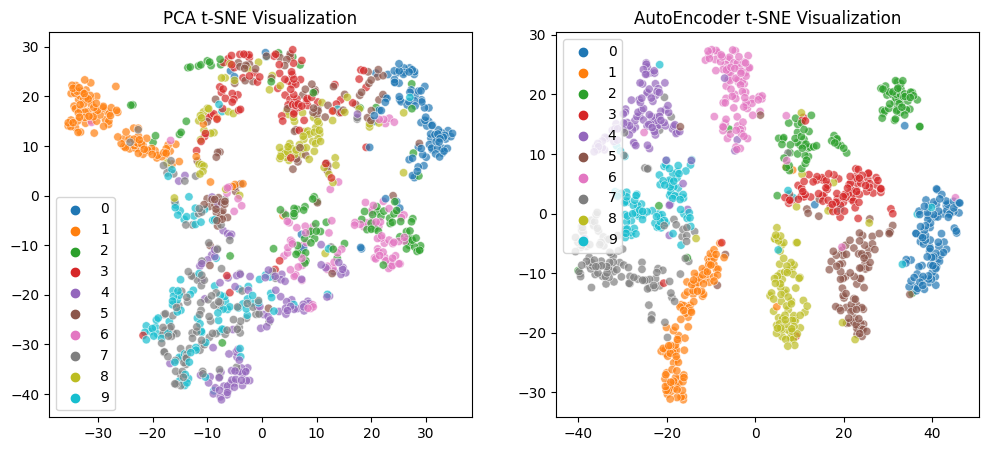

In [58]:
import seaborn as sns
tsne_pca = TSNE(n_components=2, random_state=42)
tsne_auto = TSNE(n_components=2, random_state=42)
tsne_pca_result = tsne_pca.fit_transform(pca_x_train[:1000])
tsne_auto_result = tsne_auto.fit_transform(mnist_latent_vector[:1000])
labels = y_train[:1000]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_pca_result[:, 0],y=tsne_pca_result[:, 1],hue=labels, palette="tab10", alpha=0.7)
plt.title("PCA t-SNE Visualization")
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_auto_result[:, 0],y=tsne_auto_result[:, 1],hue=labels, palette="tab10", alpha=0.7)
plt.title("AutoEncoder t-SNE Visualization")
plt.show()

## Question 2 : Train an autoencoder model for anomaly classification
- Use the dataset assigned for your group.
- Train model only on normal set. 
- Reconstruct on the test set and show the reconstruction error.
- What is the latent dimension?
- Plot TSNE for the test set.
- What is the threshold value of reconstruction error to classify as normal or anomalous ?



In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import pandas as pd

skin_lesion_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

In [3]:
train_df = pd.read_csv("/kaggle/input/dl-lab4-dataset/isic2020/train.csv")
train_images_path = "/kaggle/input/dl-lab4-dataset/isic2020/train"
train_df = train_df.sort_values(by='image_name')
train_df = train_df[["image_name", "target"]]
print(len(train_df))

30519


### Splitting the dataset into benign and malignant

In [4]:
benign_df = train_df[train_df["target"] == 0].reset_index(drop=True)
malignant_df = train_df[train_df["target"] == 1].reset_index(drop=True)

benign_df = benign_df[:10000]

print(len(benign_df))
print(len(malignant_df))

10000
541


In [5]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

class SkinLesionDataset(Dataset):
    def __init__(self, images_path, image_df, transform = None):
        super().__init__()
        self.images_path = images_path
        self.image_df = image_df
        self.transform = transform
        self._make_data()

    def _make_data(self):
        self.data = []
        for i in range(len(self.image_df)):
            img_path = os.path.join(self.images_path, self.image_df.loc[i, "image_name"]) + ".jpg"
            label = self.image_df.loc[i, "target"]
            self.data.append([img_path, label])

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

In [6]:
benign_dataset = SkinLesionDataset(train_images_path, benign_df, transform=skin_lesion_transforms)
malignant_dataset = SkinLesionDataset(train_images_path, malignant_df, transform=skin_lesion_transforms)

benign_dataloader = DataLoader(benign_dataset, batch_size=32, shuffle=True)
malignant_dataloader = DataLoader(malignant_dataset, batch_size=32, shuffle=True)

b_images, b_labels = next(iter(benign_dataloader))
m_images, m_labels = next(iter(malignant_dataloader))

print(b_images.shape, b_labels.shape)
print(m_images.shape, m_labels.shape)

torch.Size([32, 49152]) torch.Size([32])
torch.Size([32, 49152]) torch.Size([32])


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
class SkinLesionAutoEncoder(nn.Module):
    def __init__(self, input_size, in_channels = 3, latent_dim=8):
        super().__init__()
        self.input_dim = input_size * input_size * in_channels
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 256),
            nn.Tanh(),
            nn.Linear(256, 32),
            nn.Tanh(),
            nn.Linear(32, latent_dim),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.Tanh(),
            nn.Linear(32, 256),
            nn.Tanh(),
            nn.Linear(256, 2048),
            nn.Tanh(),
            nn.Linear(2048, self.input_dim),
            nn.Sigmoid()
        )

    def forward(self, X):
        latent_vector = self.encoder(X)
        decoded_output = self.decoder(latent_vector)
        return decoded_output

    def train(self, dataloader, optimizer, loss_fn, epochs=5):
        for epoch in range(epochs):
            iter_loss = 0
            for images, labels in dataloader:
                optimizer.zero_grad()
                images, labels = images.to(device), labels.to(device)
                decoded_images = self.forward(images)
                loss = loss_fn(decoded_images, images)
                loss.backward()
                optimizer.step()
                iter_loss += loss.item()
            epoch_loss = iter_loss / len(dataloader)
            print(f"Epoch : {epoch+1}, MSELoss : {epoch_loss}")

In [9]:
model = SkinLesionAutoEncoder(128, in_channels=3)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
model.train(benign_dataloader, optimizer, loss_fn, epochs=5)

Epoch : 1, MSELoss : 0.03250134841036111
Epoch : 2, MSELoss : 0.0316259501793514
Epoch : 3, MSELoss : 0.03163973507456505
Epoch : 4, MSELoss : 0.031613737975541775
Epoch : 5, MSELoss : 0.03147685061842679


### Testing the Model on the Malignant images to get the threshold value

In [10]:
test_loss = 0
errors = []
loss_fn = nn.MSELoss()
with torch.no_grad():
    for images, labels in malignant_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model.forward(images)
        loss = loss_fn(outputs, images)
        test_loss += loss.item()
        errors.append(loss.cpu().detach().numpy())
    avg_test_loss = test_loss / len(malignant_dataloader)
    print(f"Reconstruction Test Loss : {avg_test_loss}")

Reconstruction Test Loss : 0.055133551797446084


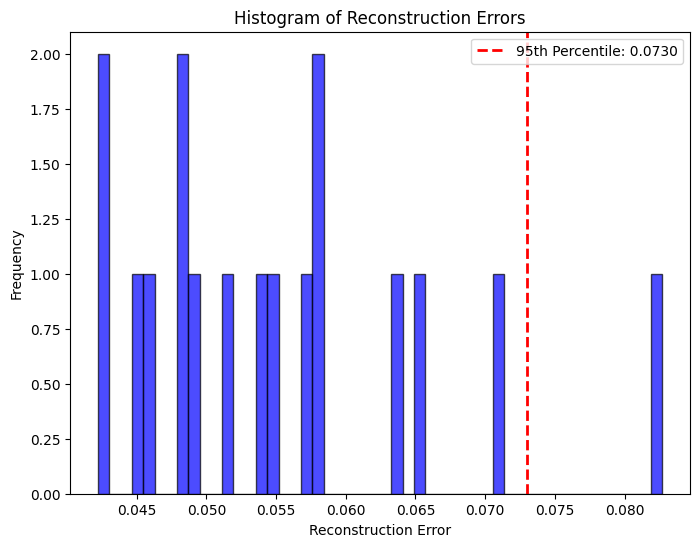

95th Percentile Error Threshold: 0.0730


In [13]:
errors = np.array(errors)

# Compute 95th percentile threshold
error_threshold = np.percentile(errors, 95)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, alpha=0.7, color='b', edgecolor='black')
plt.axvline(error_threshold, color='r', linestyle='dashed', linewidth=2, label=f'95th Percentile: {error_threshold:.4f}')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Reconstruction Errors")
plt.legend()
plt.show()

print(f"95th Percentile Error Threshold: {error_threshold:.4f}")

#### Plotting the Latent Space TSNE for test set

541


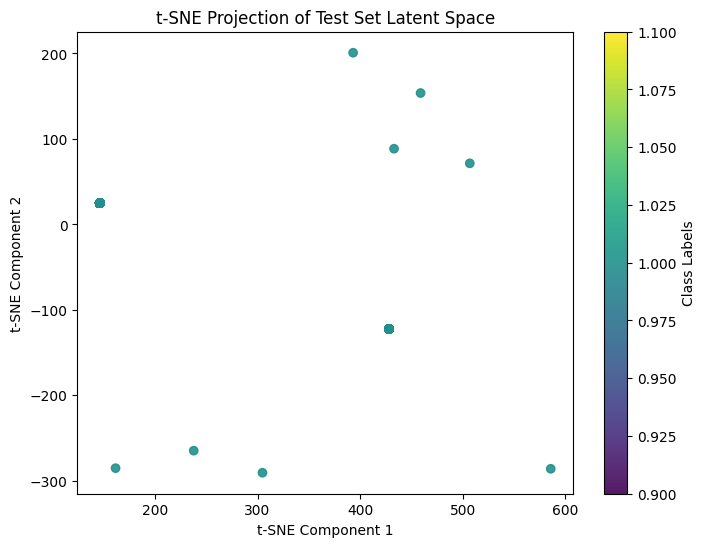

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
latent_vectors = []
labels_list = []
with torch.no_grad():
    for images, labels in malignant_dataloader:
        images = images.to(device)
        latent_space = model.encoder(images)  # Extract latent space
        latent_vectors.append(latent_space.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Convert to NumPy
latent_vectors = np.concatenate(latent_vectors, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

print(len(latent_vectors))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(latent_vectors)
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_list, alpha=0.9)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Projection of Test Set Latent Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

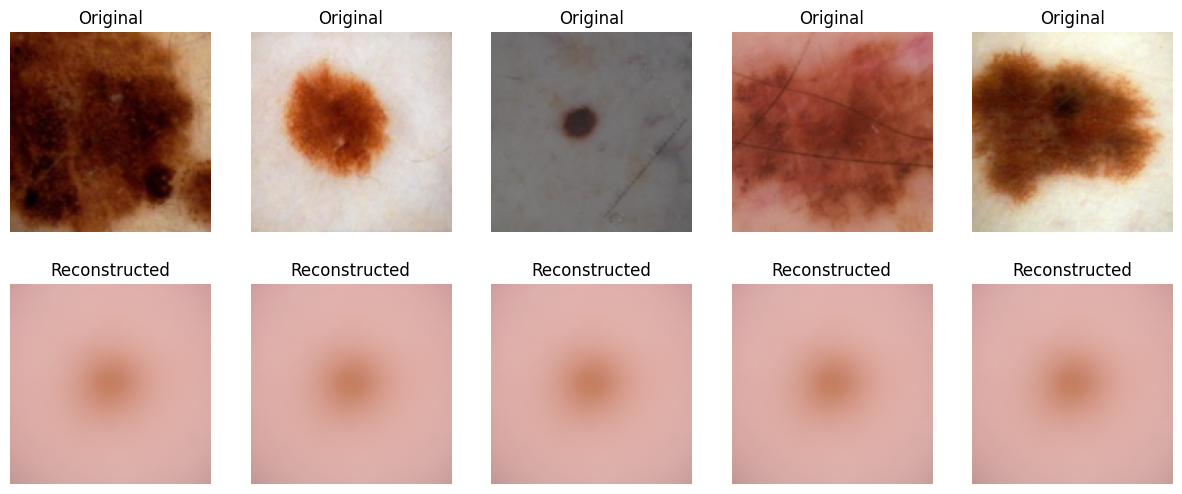

In [29]:
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

model = model.to(device)  # Ensure the model is on the correct device

# Ensure no gradients are computed
with torch.no_grad():
    for images, labels in malignant_dataloader:
        images = images[:5].to(device)  # Select the first 5 images and move to device
        
        latent_vectors = model.encoder(images)  # Encode images
        reconstructions = model.decoder(latent_vectors)  # Decode latent vectors
        
        # Ensure correct shape (B, C, H, W)
        images = images.reshape(5, 3, 128, 128).cpu()  # Move back to CPU for visualization
        reconstructions = reconstructions.reshape(5, 3, 128, 128).cpu()
        
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows (original & reconstructed)

        for i in range(5):
            # Original Image
            img = images[i].permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
            axes[0, i].imshow(img, cmap="gray" if images.shape[1] == 1 else None)
            axes[0, i].axis("off")
            axes[0, i].set_title("Original")

            # Reconstructed Image
            recon_img = reconstructions[i].permute(1, 2, 0).numpy()
            axes[1, i].imshow(recon_img, cmap="gray" if reconstructions.shape[1] == 1 else None)
            axes[1, i].axis("off")
            axes[1, i].set_title("Reconstructed")

        plt.show()
        break  # Exit after processing the first batch


In [15]:
threshold = np.percentile(errors, 95)  # 95th percentile
print(f"Threshold for anomaly detection: {threshold:.4f}")

Threshold for anomaly detection: 0.0730


### Question 3 : Variational AutoEncoder for MNIST Fashion

Epoch 1, Loss: 300.7841
Epoch 2, Loss: 271.5429
Epoch 3, Loss: 265.9154
Epoch 4, Loss: 262.5591
Epoch 5, Loss: 259.9989
Epoch 6, Loss: 258.3780
Epoch 7, Loss: 256.8288
Epoch 8, Loss: 255.4298
Epoch 9, Loss: 255.0108
Epoch 10, Loss: 253.9207


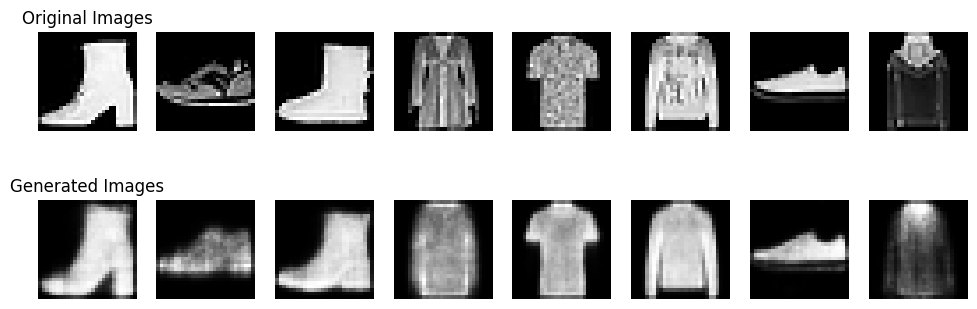

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load FashionMNIST dataset
(fX_train, fy_train), (fX_test, fy_test) = fashion_mnist.load_data()
fX_train, fX_test = fX_train / 255.0, fX_test / 255.0  # Normalize
fX_train, fX_test = np.array(fX_train), np.array(fX_test)

# Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.labels = y
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.transform(self.data[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Create test dataset and dataloader
fashion_test_dataset = FashionMNISTDataset(fX_test, fy_test)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=16, shuffle=True)

# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.Tanh(),
            nn.Linear(256, 2 * latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim

    def forward(self, x):
        params = self.encoder(x)
        mu, logvar = params[:, :self.latent_dim], params[:, self.latent_dim:]
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return self.decoder(z), mu, logvar

# Loss function
def vae_loss_fn(reconstruction, X, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(reconstruction, X.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for X, _ in fashion_test_loader:
        X = X.to(device)
        optimizer.zero_grad()
        recon_X, mu, logvar = vae(X)
        loss = vae_loss_fn(recon_X, X, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(fashion_test_loader.dataset):.4f}")

# Generate reconstructed images
vae.eval()
original_images, _ = next(iter(fashion_test_loader))  # Get a batch of test images
original_images = original_images.to(device)
reconstructed_images, _, _ = vae(original_images)
original_images = original_images.cpu().detach().numpy()
reconstructed_images = reconstructed_images.cpu().detach().numpy()

# Function to plot original and generated images
def compare_images(original, generated, num_images=8):
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    
    for i in range(num_images):
        axes[0, i].imshow(original[i].reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")

        axes[1, i].imshow(generated[i].reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Generated Images", fontsize=12)
    plt.show()

# Show original vs reconstructed images
compare_images(original_images, reconstructed_images)


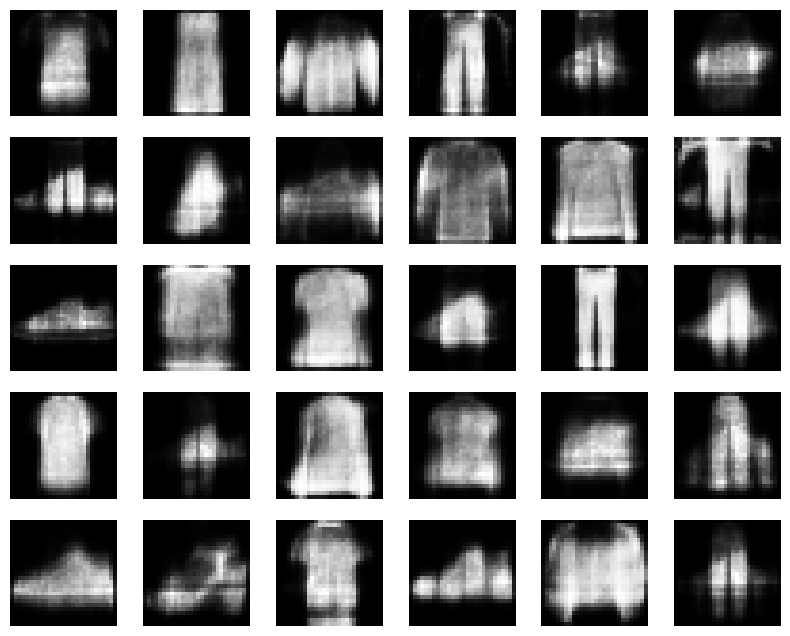

In [6]:
vae.eval()
z = torch.randn(30, vae.latent_dim).to(device)
generated_samples = vae.decoder(z).cpu().detach().numpy()

# Function to plot generated images
import matplotlib.pyplot as plt

def plot_images(images, n_rows=5, n_cols=6):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

plot_images(generated_samples)